In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Easy21:

    def __init__(self, max_length=1000):
        self.max_length = max_length


    def reset(self):
        self.player_first_card_val = np.random.choice(10) + 1
        self.dealer_first_card_val = np.random.choice(10) + 1

        self.player_sum = self.player_first_card_val
        self.dealer_sum = self.dealer_first_card_val

        self.state = [self.dealer_first_card_val, self.player_sum]

        self.player_goes_bust = False
        self.dealer_goes_bust = False

        self.ret = 0
        self.terminal = False
        self.t = 0

        return self.state


    def step(self, action):
        # action 1: hit   0: stick
        # color: 1: black   -1: red
        r = 0

        if action == 1:
            self.player_card_val = np.random.choice(10) + 1
            self.player_card_col = np.random.choice([-1, 1], p=[1./3., 2./3.])

            self.player_sum += (self.player_card_val * self.player_card_col)
            self.player_goes_bust = self.check_go_bust(self.player_sum)

            if self.player_goes_bust == 1:
                r = -1
                self.terminal = True

        if not self.terminal and self.dealer_sum < 17:
            self.dealer_card_val = np.random.choice(10) + 1
            self.dealer_card_col = np.random.choice([-1, 1], p=[1./3., 2./3.])

            self.dealer_sum += (self.dealer_card_val * self.dealer_card_col)
            self.dealer_goes_bust = self.check_go_bust(self.dealer_sum)

            if self.dealer_goes_bust == 1:
                r = 1
                self.terminal = True

        self.t += 1
        self.ret += r

        if not self.terminal and self.t == self.max_length:
            self.terminal = True
            if self.player_sum > self.dealer_sum: r = 1
            elif self.player_sum < self.dealer_sum: r = -1

        if self.terminal: return 'Terminal', r, self.terminal
        else:
            self.state[1] = self.player_sum
            return self.state, r, self.terminal


    def check_go_bust(self, Sum):
        return bool(Sum > 21 or Sum < 1)

In [3]:
## Monte Carlo -- one episode
def monte_carlo(Q, Returns, count_state, count_state_action):
    
    # Run per episode, loop followed runs whole epoch
    
    appeared = np.zeros([10, 21, 2], dtype=int)

    actions = []
    rewards = []
    s = env.reset()
    states = [s]
    
    # Gets the trace for each episode
    while True:
        action_greedy = Q[s[0]-1, s[1]-1, :].argmax()
        count_state[s[0]-1, s[1]-1] += 1
        epsilon = count_constant / float(count_constant + count_state[s[0]-1, s[1]-1])
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        actions.append(action)

        s, r, term = env.step(action=action)
        rewards.append(r)

        if term: break
        else: states.append(s.copy())
    
    
    # Calculates the return for each state that episode 
    for t in range(len(states)):
        # Checks to see if state has appeared before or not, if == 0 then calculated reward, if == 1 then been already
        if appeared[states[t][0]-1, states[t][1]-1, actions[t]] == 0:
            # Sums all rewards in trace and add to the return matrix
            Returns[states[t][0]-1, states[t][1]-1, actions[t]] += sum(rewards[t:])
            # Updates count for how many time visited that state to calc the mean
            count_state_action[states[t][0]-1, states[t][1]-1, actions[t]] += 1
            # Calculate the Q for that episode for each state (note matrix is zero), note returns matrix tracks 
            # return over life, so need to divide by number of times visited a state/state, action paid
            Q[states[t][0]-1, states[t][1]-1, actions[t]] = \
                Returns[states[t][0]-1, states[t][1]-1, actions[t]] / \
                float(count_state_action[states[t][0]-1, states[t][1]-1, actions[t]])
            # Updates where we have appeared already, doing first only visit
            appeared[states[t][0]-1, states[t][1]-1, actions[t]] = 1

    return Q, Returns, count_state, count_state_action

In [4]:
## Monte Carlo
Q_MC = np.zeros([10, 21, 2]) # Q(s, s, a)
Returns = np.zeros([10, 21, 2]) # empirical first-visit returns
count_state_action = np.zeros([10, 21, 2], dtype=int) # N(s, a)
count_state = np.zeros([10, 21], dtype=int) # N(s)
count_constant = 100

n_episodes = 20000
env = Easy21()

for i_epi in range(n_episodes):
    Q_MC, Returns, count_state, count_state_action = monte_carlo(Q_MC, Returns, count_state, count_state_action)

V_MC = Q_MC.max(axis=2)

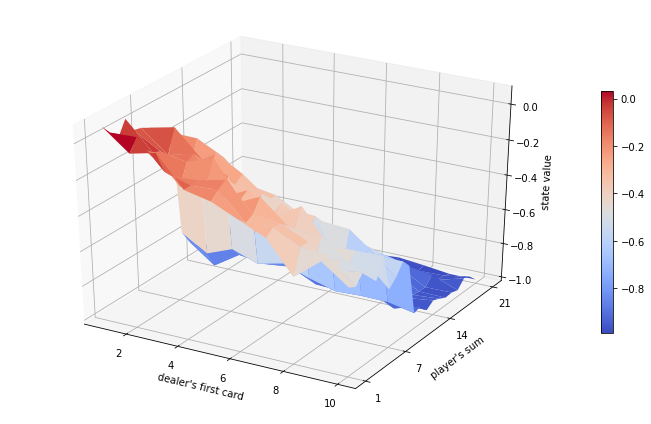

In [5]:
## Monte Carlo -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_MC, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

In [6]:
# SARSA method for each episode:

def SARSA(Q_S, state_count, count_state_action):
    
    initial_state = env.reset()
    states = [initial_state]
    
    state = np.copy(initial_state)
    
    # Choose action based on dealer, player state
    action_greedy = Q_S[state[0]-1,state[1]-1,:].argmax()
    epsilon = count_constant / float(count_constant+state_count[state[0]-1,state[1]-1])
    
    # Now calc action to actually take
    action = np.random.choice([action_greedy,1-action_greedy],p=[1.-epsilon/2.,epsilon/2.])
    
    while True:
        # Update state count
        state_count[state[0]-1,state[1]-1] += 1
        count_state_action[state[0]-1, state[1]-1, action] += 1
        step_size = 1. / float(count_state_action[state[0]-1, state[1]-1, action])
        
        new_state, reward, term = env.step(action)
        
        # If new_state is terminal
        if term:
            TD_error = reward-Q_S[state[0]-1,state[1]-1,action]
            Q_S[state[0]-1,state[1]-1,action] = step_size*(TD_error)
            break
        
        # Calc for Q(S',A') based on new state if not terminal
        else:
            action_greedy_new = Q_S[new_state[0]-1,new_state[1]-1,:].argmax()
            action_new = np.random.choice([action_greedy_new,1-action_greedy_new],p=[1-epsilon/2.,epsilon/2.])
            
            # Update Q value for new reward
            TD_error = reward + Q_S[new_state[0]-1,new_state[1]-1,action_new] - Q_S[state[0]-1,state[1]-1,action]
            Q_S[state[0]-1,state[1]-1,action] += step_size*(TD_error)
            
            state = np.copy(new_state)
            action = action_new
            
    return Q_S, state_count, count_state_action


In [7]:
## SARSA
Q_S = np.zeros([10, 21, 2]) # Q(s, s, a)
count_state = np.zeros([10, 21], dtype=int) # N(s)
count_state_action = np.zeros([10, 21, 2], dtype=int) # N(s, a)
count_constant = 100

n_episodes = 1000
env = Easy21()

for i_epi in range(n_episodes):
    Q_S, count_state, count_state_action = SARSA(Q_S, count_state, count_state_action)

V_S = Q_S.max(axis=2)

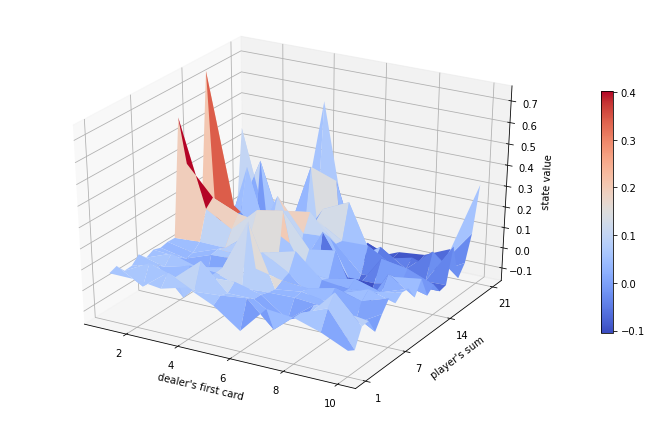

In [8]:
## SARSA -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_S, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

In [9]:
def Q_learning(Q, count_state, count_state_action):
    initial_state = env.reset()
    states = [initial_state]
    
    state = np.copy(initial_state)

    
    while True:
        # Now calc action to take greedily
        action_greedy = Q_S[state[0]-1,state[1]-1,:].argmax()

        
        # Update state count
        state_count[state[0]-1,state[1]-1] += 1
        count_state_action[state[0]-1, state[1]-1, action] += 1
        step_size = 1. / float(count_state_action[state[0]-1, state[1]-1, action])
        
        new_state, reward, term = env.step(action_greedy)
        
        # If new_state is terminal
        if term:
            TD_error = reward-Q_S[state[0]-1,state[1]-1,action]
            Q_S[state[0]-1,state[1]-1,action] = step_size*(TD_error)
            break
        
        # Calc for Q(S',A') based on new state if not terminal
        else:
            action_greedy_new = Q_S[new_state[0]-1,new_state[1]-1,:].argmax()
            action_new = np.random.choice([action_greedy_new,1-action_greedy_new],p=[1-epsilon/2.,epsilon/2.])
            
            # Update Q value for new reward
            TD_error = reward + Q_S[new_state[0]-1,new_state[1]-1,action_new] - Q_S[state[0]-1,state[1]-1,action]
            Q_S[state[0]-1,state[1]-1,action] += step_size*(TD_error)
            
            state = np.copy(new_state)
            action = action_new
            
    return Q_S, state_count, count_state_action
    

In [10]:
## SARSA(lambda) -- one episode
def SARSA_lambda(Q, count_state, count_state_action, decay):
    s = env.reset()
    elig_trace = np.zeros([10, 21, 2])

    action_greedy = Q[s[0]-1, s[1]-1, :].argmax()
    count_state[s[0]-1, s[1]-1] += 1
    epsilon = count_constant / float(count_constant + count_state[s[0]-1, s[1]-1])
    action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. -epsilon/2., epsilon/2.])

    while True:
        count_state_action[s[0]-1, s[1]-1, action] += 1
        stepsize = 1. / float(count_state_action[s[0]-1, s[1]-1, action])

        s_next, r, term = env.step(action=action)

        elig_trace[s[0]-1, s[1]-1, action] += 1

        if term:
            TD_error = r - Q[s[0]-1, s[1]-1, action]
            Q += (stepsize * TD_error * elig_trace)
            break

        else:
            action_greedy = Q[s_next[0]-1, s_next[1]-1, :].argmax()
            count_state[s_next[0]-1, s_next[1]-1] += 1
            epsilon = count_constant / float(count_constant + count_state[s_next[0]-1, s_next[1]-1])
            action_next = np.random.choice([action_greedy, 1 - action_greedy], p=[1. -epsilon/2., epsilon/2.])

            TD_error = r + Q[s_next[0]-1, s_next[1]-1, action_next] - Q[s[0]-1, s[1]-1, action] # gamma = 1

            Q += (stepsize * TD_error * elig_trace)
            elig_trace = elig_trace * decay

            s = np.array(s_next)
            action = action_next
        

    return Q, count_state, count_state_action

In [11]:
## SARSA(lambda) -- MSE vs. lambda
n_episodes = 1
env = Easy21()

count_constant = 100
n_state_action = 10 * 21 * 2

Decay = np.arange(0, 1.1, 0.1)
mse_Q = np.zeros(len(Decay))

for i_dec in range(len(Decay)):
    Q_SARSA = np.zeros([10, 21, 2]) # Q(s, a)
    count_state_action = np.zeros([10, 21, 2], dtype=int) # N(s, a)
    count_state = np.zeros([10, 21], dtype=int) # N(s)

    for i_epi in range(n_episodes):
        Q_SARSA, count_state, count_state_action = \
            SARSA_lambda(Q_SARSA, count_state, count_state_action, Decay[i_dec])

    mse_Q[i_dec] = np.sum(np.square(Q_SARSA - Q_MC)) / float(n_state_action)

print("The best lambda is:", Decay[mse_Q.argmin()])

The best lambda is: 0.7000000000000001


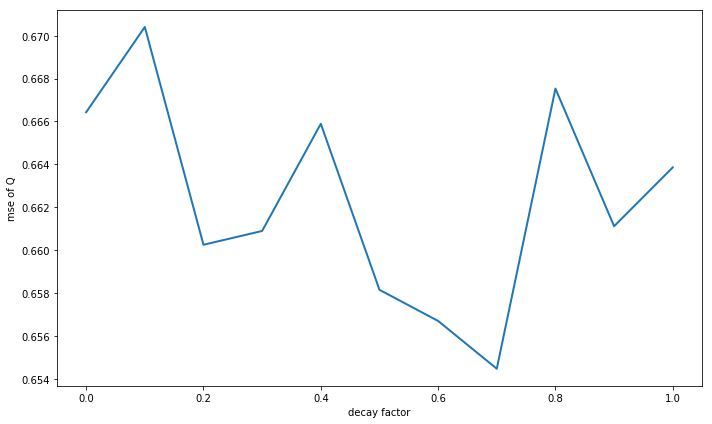

In [12]:
## SARSA(lambda) -- MSE vs. lambda plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(Decay, mse_Q, linewidth=2)

ax.set_xlabel("decay factor")
ax.set_ylabel("mse of Q")
fig.tight_layout()

plt.show()

In [13]:
## SARSA(lambda) function approximation -- coarse coding
def coarse_coding(s, a):
    v = np.zeros(3, dtype=int)
    for i in range(3):
        if (3 * i) <= s[0] <= (3 * (i+1)): v[i] = 1

    v_ = np.zeros(6, dtype=int)
    for i in range(6):
        if (3 * i) <= s[1] <= (3 * i + 5): v_[i] = 1
    v = np.append(v, v_)

    v_ = np.zeros(2, dtype=int)
    v_[a] = 1

    return np.append(v, v_)

In [14]:
## SARSA(lambda) function approximation -- one episode
def SARSA_lambda_func_approx(w, decay):
    epsilon = 0.05
    stepsize = 0.01

    s = env.reset()
    elig_trace = np.zeros(len(w))

    V = np.vstack([coarse_coding(s, 0), coarse_coding(s, 1)])
    Q = np.dot(V, w)

    action_greedy = Q.argmax()
    action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. -epsilon/2., epsilon/2.])

    v = np.array(V[action])
    q = Q[action]
    q_ = 0.

    while True:
        s_next, r, term = env.step(action=action)

        elig_trace = decay * elig_trace + (1. - stepsize * decay * np.dot(elig_trace, v)) * v

        if term:
            TD_error = r - q
            w += (stepsize * (TD_error + q - q_) * elig_trace - stepsize * (q - q_) * v)
            break

        else:
            V_next = np.vstack([coarse_coding(s_next, 0), coarse_coding(s_next, 1)])
            Q_next = np.dot(V_next, w)

            action_greedy = Q_next.argmax()
            action_next = np.random.choice([action_greedy, 1 - action_greedy], p=[1. -epsilon/2., epsilon/2.])

            q_next = Q_next[action_next]

            TD_error = r + q_next - q
            w += (stepsize * (TD_error + q - q_) * elig_trace - stepsize * (q - q_) * v)

            q_ = q_next
            v = np.array(V_next[action_next])
            action = action_next

            q = np.dot(w, v)

    return w

In [15]:
## SARSA(lambda) function approximation -- MSE vs. lambda
n_episodes = 100
env = Easy21()

Decay = np.arange(0, 1.1, 0.1)
mse_Q_approx = np.zeros(len(Decay))

n_state_action = 10 * 21 * 2

feature = np.zeros([10, 21, 2, 11])
for i in range(10):
    for j in range(21):
        for a in range(2):
            feature[i, j, a, :] = coarse_coding([i, j], a)

for i_dec in range(len(Decay)):
    w = np.zeros(11)
    for i_epi in range(n_episodes):
        w = SARSA_lambda_func_approx(w, Decay[i_dec])

    Q_SARSA_approx = np.zeros([10, 21, 2])
    for i in range(10):
        for j in range(21):
            for a in range(2):
                Q_SARSA_approx[i, j, a] = np.dot(w, feature[i, j, a, :])

    mse_Q_approx[i_dec] = np.sum(np.square(Q_SARSA_approx - Q_MC)) / float(n_state_action)

print("The best lambda is:", Decay[mse_Q_approx.argmin()])

The best lambda is: 0.8


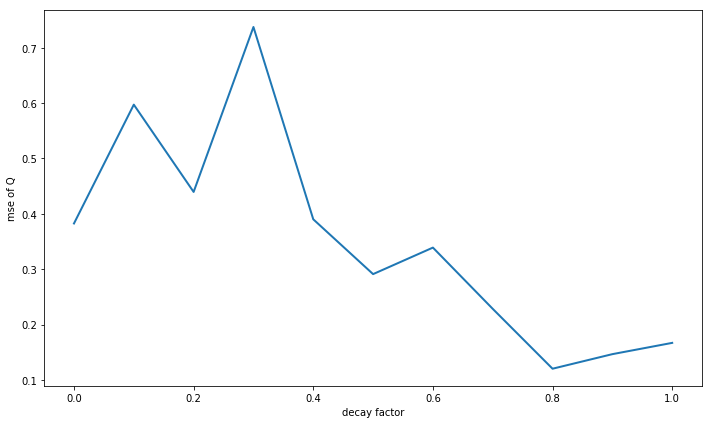

In [16]:
## SARSA(lambda) function approximation -- MSE vs. lambda plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(Decay, mse_Q_approx, linewidth=2)

ax.set_xlabel("decay factor")
ax.set_ylabel("mse of Q")
fig.tight_layout()

plt.show()